In [8]:
!pip -q install arch
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from arch import arch_model
from arch.unitroot import KPSS, ZivotAndrews
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import gennorm, norm

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

from google.colab import drive
drive.mount('/content/drive')
%run "/content/drive/MyDrive/FINC612 A02/functions.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
DATA_PATH  = "/content/drive/MyDrive/FINC612 A02/data.xlsx"
SHEET_NAME = "Part3"
COLUMN     = "x"

df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
data = pd.to_numeric(df[COLUMN], errors="coerce").dropna()

In [10]:
#1a: Estimate the Andrews-Zivot and KPSS statistics
print("\n=== Zivot-Andrews Test (Structural Break) ===")
za_test = ZivotAndrews(data, method="bic")
print(za_test.summary())

print("\n=== KPSS Test ===")
kpss_test = KPSS(data)
print(kpss_test.summary())


=== Zivot-Andrews Test (Structural Break) ===
        Zivot-Andrews Results        
Test Statistic                -32.925
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.

=== KPSS Test ===
    KPSS Stationarity Test Results   
Test Statistic                  0.032
P-value                         0.968
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


1a.

The Zivot–Andrews test gave a statistic of −32.925 (p = 0.000), far below all critical values, so we reject the null of a unit root and conclude the series is stationary with a possible break.

The KPSS test gave a statistic of 0.032 (p = 0.968), well below critical values, so we fail to reject the null of stationarity.

Overall, both tests confirm the data are stationary.

In [11]:
#1b.Conduct the Ljung-Box test on the series and the squared series.
# Ljung-Box test on returns
lb_resid = acorr_ljungbox(data, lags=30, return_df=True)
print("Ljung-Box test on residuals:")
print(lb_resid)


# Ljung-Box test on squared residuals (for ARCH effects)
lb_sq_resid = acorr_ljungbox(data**2, lags=30, return_df=True)
print("\nLjung-Box test on squared residuals (ARCH effects):")
print(lb_sq_resid)

Ljung-Box test on residuals:
      lb_stat  lb_pvalue
1    1.401812   0.236420
2    5.273527   0.071593
3    5.290463   0.151722
4    5.634645   0.228145
5    6.300419   0.278074
6    7.327420   0.291626
7   12.183455   0.094685
8   12.795718   0.119074
9   14.429395   0.107850
10  14.587142   0.147855
11  17.008488   0.107625
12  18.622085   0.098066
13  19.097147   0.120122
14  19.480129   0.147402
15  21.077873   0.134360
16  21.145333   0.172992
17  21.173125   0.218642
18  22.176770   0.224232
19  22.867865   0.243212
20  23.004044   0.288596
21  24.958970   0.248945
22  25.737643   0.263117
23  27.620363   0.230479
24  27.973927   0.261141
25  30.715144   0.198625
26  30.715202   0.239047
27  30.748573   0.281587
28  30.842359   0.324125
29  32.250016   0.309007
30  32.412610   0.348590

Ljung-Box test on squared residuals (ARCH effects):
       lb_stat     lb_pvalue
1    62.268840  2.996288e-15
2   144.595584  3.994551e-32
3   206.217766  1.912384e-44
4   233.117338  2.814932e-4

1b.

The Ljung–Box test on residuals shows that all p-values are above 0.05, so there is no autocorrelation in the mean. The test on squared residuals gives p-values that are essentially zero. We strongly reject the null of no autocorrelation in the squared series, which are ARCH effects.

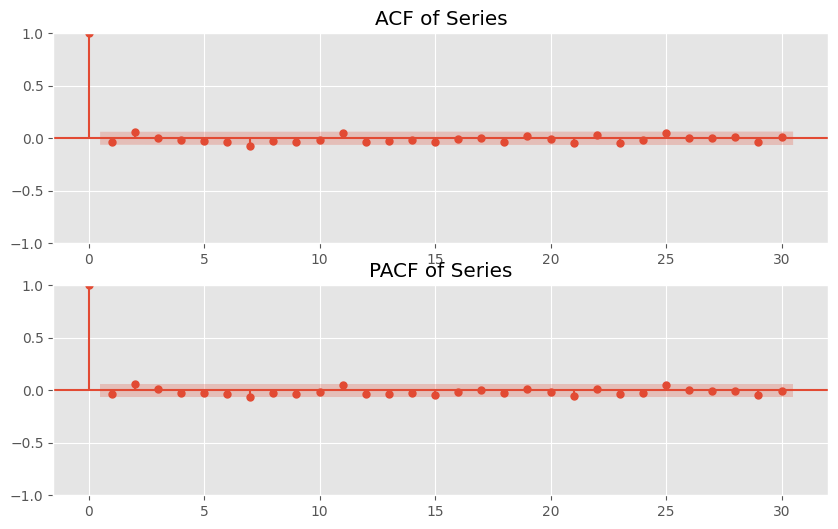

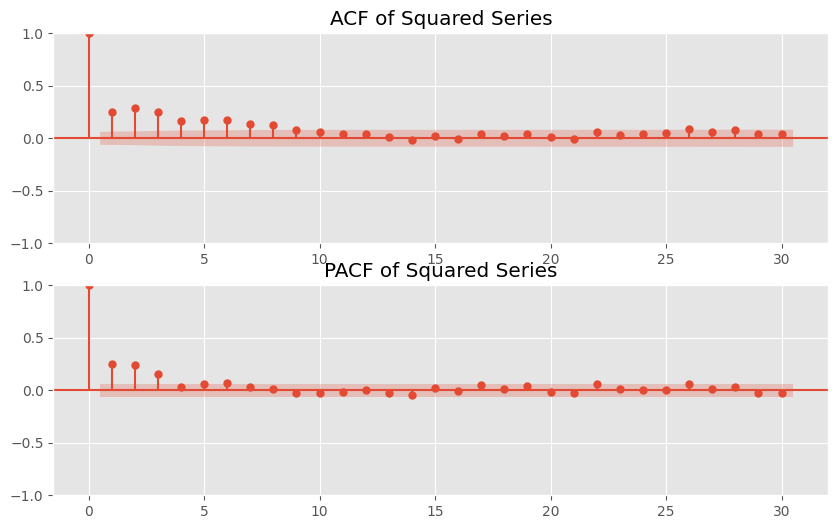

In [12]:
#1c.Visualize the ACF and PACF plots.

# Plot ACF and PACF of Series
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(data, lags=30, ax=ax[0])
plot_pacf(data, lags=30, ax=ax[1])
ax[0].set_title("ACF of Series")
ax[1].set_title("PACF of Series")
plt.show()

# Plot ACF and PACF of Squared Series
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(data**2, lags=30, ax=ax[0])
plot_pacf(data**2, lags=30, ax=ax[1])
ax[0].set_title("ACF of Squared Series")
ax[1].set_title("PACF of Squared Series")
plt.show()

1c.

The residuals show no serial correlation in the mean, but the squared residuals display strong autocorrelation, which is consistent with volatility clustering.

According to the lecture slides, GARCH(1,1) is often sufficient for financial return series, so the expected optimal model is GARCH(1,1).

In [13]:
# 2a.Estimate the GARCH(1,1) model
garch_model = arch_model(data, mean='Constant', vol='GARCH', p=1, q=1, dist='normal').fit(disp='off')
print(garch_model.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      x   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1326.14
Distribution:                  Normal   AIC:                           2660.27
Method:            Maximum Likelihood   BIC:                           2679.90
                                        No. Observations:                 1000
Date:                Sun, Sep 28 2025   Df Residuals:                      999
Time:                        05:17:01   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0783  2.537e-02      3.087  2.025e-03 [2.858e-0

2a.

The GARCH(1,1) model shows that the mean (mu = 0.0783, p = 0.002) is significantly positive. Both alpha (0.2520) and beta (0.6722) are highly significant, indicating strong volatility clustering. Since alpha + beta = 0.9242 < 1, the process is stationary, but volatility is highly persistent, which is consistent with typical financial return series.

In [14]:
# 2b.Perform the sign bias test.
def sign_bias_test(std_resid):

    # Create indicator variables
    sign_bias = (std_resid.shift(1) < 0).astype(int)      # I_{t-1}^{-}
    neg_size = sign_bias * std_resid.shift(1)             # I_{t-1}^{-} * e_{t-1}
    pos_size = (1 - sign_bias) * std_resid.shift(1)       # I_{t-1}^{+} * e_{t-1}

    # Get squared residuals as proxy for conditional variance
    squared = std_resid ** 2

    # Run regression for: squared residuals ~ constant + sign bias
    X1 = sm.add_constant(sign_bias)
    reg1 = sm.OLS(squared, X1, missing='drop').fit()
    print("Sign Bias Test")
    print(reg1.summary())

    # Negative Size Bias
    X2 = sm.add_constant(neg_size)
    reg2 = sm.OLS(squared, X2, missing='drop').fit()
    print("\nNegative Size Bias Test")
    print(reg2.summary())

    # Positive Size Bias
    X3 = sm.add_constant(pos_size)
    reg3 = sm.OLS(squared, X3, missing='drop').fit()
    print("\nPositive Size Bias Test")
    print(reg3.summary())

    # Step 8: Joint test (F-test)
    X_joint = sm.add_constant(pd.concat([sign_bias, neg_size, pos_size], axis=1))
    reg_joint = sm.OLS(squared, X_joint, missing='drop').fit()
    print("\nJoint Test for Sign and Size Bias")
    print(reg_joint.summary())

std_resid = garch_model.std_resid
sign_bias_test (std_resid)

Sign Bias Test
                            OLS Regression Results                            
Dep. Variable:              std_resid   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.484
Date:                Sun, 28 Sep 2025   Prob (F-statistic):             0.0345
Time:                        05:17:01   Log-Likelihood:                -1757.8
No. Observations:                1000   AIC:                             3520.
Df Residuals:                     998   BIC:                             3529.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9031      0.064     

2b.

From the Sign Bias Test results, we can see:
- Sign Bias Test: coefficient = 0.1882, p = 0.034 which is significant and indicates a sign effect.
- Negative Size Bias Test: coefficient = -0.0855, p = 0.234 which is not significant.
- Positive Size Bias Test: coefficient = -0.2434, p = 0,003 which is significant and indicates a positive size effect.
- Joint Test: prob = 0.0261 which is significant and indicates at least one of the Bias effect.

Overall, the GARCH(1.1) model is not appropriate.


In [15]:
# Estimate the EGARCH model to proceed
egarch_model = arch_model(data, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='ged').fit(disp='off')
print(egarch_model.summary())

std_resid = egarch_model.std_resid
sign_bias_test (std_resid)


                           Constant Mean - EGARCH Model Results                           
Dep. Variable:                                  x   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 EGARCH   Log-Likelihood:               -1317.70
Distribution:      Generalized Error Distribution   AIC:                           2647.40
Method:                        Maximum Likelihood   BIC:                           2676.84
                                                    No. Observations:                 1000
Date:                            Sun, Sep 28 2025   Df Residuals:                      999
Time:                                    05:17:01   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------

2b. Estimate the EARCH model to proceed

From the Sign Bias Test results, we can see:
- Sign Bias Test: coefficient = -0.025, p = 0.977, which is not significant.
- Negative Size Bias Test: coefficient = 0.0711, p = 0.328, which is not significant.
- Positive Size Bias Test: coefficient = -0.0735, p = 0.331, which is not significant.
- Joint Test: prob = 0.293, which is not significant.

Compared to GARCH(1.1) model, EGARCH has low AIC and BIC.

Overall, the EGARCH model is more suitable.

                           Constant Mean - EGARCH Model Results                           
Dep. Variable:                                  x   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 EGARCH   Log-Likelihood:               -1317.70
Distribution:      Generalized Error Distribution   AIC:                           2647.40
Method:                        Maximum Likelihood   BIC:                           2676.84
                                                    No. Observations:                 1000
Date:                            Sun, Sep 28 2025   Df Residuals:                      999
Time:                                    06:07:27   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------

{'weibull exponential': array([1.32824386]),
 'unrestricted log-likelihood': array([-394.48754645]),
 'restricted log-likelihood': array([-402.52467419]),
 'log-likelihood': array([16.07425547]),
 'log-likelihood ratio test statistic': array([6.09064373e-05]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Reject H0'}

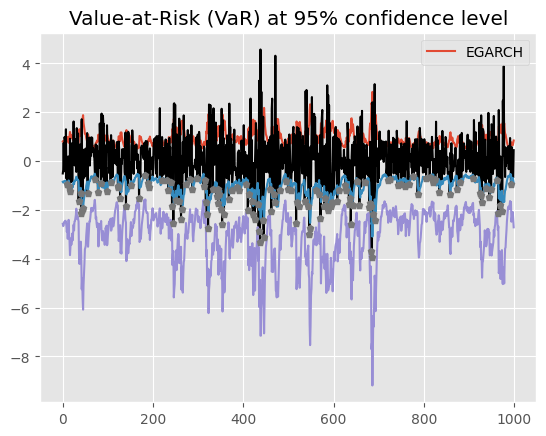

In [33]:
#3a. Conduct the Ljung-Box test on the standardized residuals and squared standardized residuals.
result = arch_model (data, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='ged').fit(disp='off')
print(result.summary())

# Get raw residuals (εₜ)
std_residuals = result.std_resid.dropna()

# Ljung-Box test on standardized residuals
lb_resid = acorr_ljungbox(std_residuals, lags=30, return_df=True)
print("Ljung-Box test on standardized residuals:")
print(lb_resid)
# Significant autocorrelations on returns

# Ljung-Box test on squared standardized residuals
lb_sq_resid = acorr_ljungbox(std_residuals**2, lags=30, return_df=True)
print("\nLjung-Box test on squared standardized residuals):")
print(lb_sq_resid)

# 3b.
returns = data.dropna()
# Get conditional volatility (σₜ)
conditional_volatility = result.conditional_volatility
conditional_volatility.plot(label="EGARCH")
plt.legend()

# Value-at-Risk
quantile = 0.95  # 95% confidence level
fitted_mean = pd.Series(result.params["mu"], index=returns.index)
VaR = fitted_mean + gennorm.ppf(1-quantile, beta=result.params["nu"])*result.conditional_volatility
violations = VaR.values > returns.values
violations_ind = np.where(violations)[0]
print(failure_rate(violations))
print(len(violations_ind) / len(returns))
CVaR = fitted_mean - result.conditional_volatility * gennorm.pdf(gennorm.ppf(quantile, beta=result.params["nu"]), beta=result.params["nu"]) / (1-quantile)

plt.plot(returns, color='black')
plt.plot(VaR, label="VaR")
plt.plot(CVaR, label="CVaR")
plt.plot(returns.iloc[violations], marker='p', markersize=5, linestyle='')
plt.title("Value-at-Risk (VaR) at {}% confidence level".format(round(100*quantile)))

kupiec_test(violations, var_conf_level=quantile, conf_level=0.99)
duration_test(violations, conf_level=0.99)
